# Configure Environment

## Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import packages

In [2]:
!apt install python3-cartopy
!pip install rasterio
!pip install shapely
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python3-pkg-resources python3-pyshp python3-shapely python3-six
Suggested packages:
  python3-matplotlib python3-owslib python3-pil python3-pyepsg python3-scipy
  python3-setuptools python-shapely-doc
The following NEW packages will be installed:
  python3-cartopy python3-pkg-resources python3-pyshp python3-shapely
  python3-six
0 upgraded, 5 newly installed, 0 to remove and 31 not upgraded.
Need to get 5,570 kB of archives.
After this operation, 10.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2 [98.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-pyshp all 1.2.12+ds-1 [31.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-shapely amd64 1.6.4-1 [213 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/ma

In [0]:
# IO packages
import os
import json
import csv
# Data processing
import numpy as np
from operator import itemgetter
import rasterio
# from rasterio.features import shapes
# from shapely.geometry import shape
# Visualization
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import geopandas as gpd
import pprint

import sys
sys.path.append("/content/drive/My Drive/lasero")
from utils import model_assessment

In [0]:
meta_dir = "/content/drive/My Drive/Metadata"

## Define data paths

In [13]:
base_dir = '/content/drive/My Drive/'
output_dir = os.path.join(base_dir, 'output')
input_components = [i for i in os.listdir(output_dir) if 'dataset' in i]
print(input_components)
selected_input_component = input_components[0]
print(selected_input_component)
input_component_dir = os.path.join(output_dir, selected_input_component)
print()

opt_components = [i for i in os.listdir(input_component_dir)]
print(opt_components)
selected_opt_component = opt_components[0]
print(selected_opt_component)
opt_component_dir = os.path.join(input_component_dir, selected_opt_component)
print()

callback_components = [i for i in os.listdir(opt_component_dir)]
print(callback_components)
selected_callback_component = callback_components[1]
print(selected_callback_component)
print()

session_name = os.path.join(selected_input_component, selected_opt_component, selected_callback_component)

print(session_name)

['dataset=one_percent_bands=1-4-8-_weights=none']
dataset=one_percent_bands=1-4-8-_weights=none

['opt=Adam_loss=categorical_crossentropy_lr=0.001']
opt=Adam_loss=categorical_crossentropy_lr=0.001

['batch=4_epochs=50_lrmonitor=val_loss_factor=0.5_patience=3_min=0.0001_stopmonitor=val_loss_patience=9', 'batch=5_epochs=50_lrmonitor=val_loss_factor=0.5_patience=3_min=0.0001_stopmonitor=val_loss_patience=9']
batch=5_epochs=50_lrmonitor=val_loss_factor=0.5_patience=3_min=0.0001_stopmonitor=val_loss_patience=9

dataset=one_percent_bands=1-4-8-_weights=none/opt=Adam_loss=categorical_crossentropy_lr=0.001/batch=5_epochs=50_lrmonitor=val_loss_factor=0.5_patience=3_min=0.0001_stopmonitor=val_loss_patience=9


In [0]:
model_dir = os.path.join(base_dir, "models")
model_name = os.path.join(session_name, 'val_loss') 
model_path = os.path.join(model_dir, model_name)
output_path = os.path.join(base_dir, "output", model_name)
label_path = os.path.join(base_dir, "test_chunks")

In [0]:
qc_dir = os.path.join(base_dir, "qc")
qc_chunk_dir = os.path.join(qc_dir, "manual_labels")
window_path = os.path.join(qc_dir, "chunk_windows.json")

model_results = model_assessment.TestRegion(window_path)

In [16]:
model_results.load_groundtruth()
print(output_path)
model_output = model_results.load_output_mosaics(output_path)

diff_rasters = model_results.generate_diffs(model_output)
diff_hists = model_results.generate_diff_histograms(diff_rasters)

diff_stats = {}
for i in diff_hists:
    diff_stats[i] = model_assessment.calculate_results(diff_hists[i])


/content/drive/My Drive/output/dataset=one_percent_bands=1-4-8-_weights=none/opt=Adam_loss=categorical_crossentropy_lr=0.001/batch=5_epochs=50_lrmonitor=val_loss_factor=0.5_patience=3_min=0.0001_stopmonitor=val_loss_patience=9/val_loss


In [17]:
acc_sum = 0
for i in diff_stats:
    class_acc = diff_stats[i]['classification_accuracy']
    acc_sum += class_acc
    print(i, class_acc)

print(acc_sum / len(diff_stats))

LC80311222014338LGN00 0.057738836633309
LC80631112014002LGN00 0.13609902977584476
LC81041072013303LGN00 0.06010287149163663
LC81431082013352LGN00 0.3199290756414974
LC81681112014002LGN00 0.140396889443181
LC82071182013336LGN00 0.08387421225503293
LC82091172014001LGN00 0.0031798034303333975
LC82131132013362LGN00 0.04660698255574156
LC82201072015017LGN00 0.1518170013696437
0.11108274473291338


# Load output and manual chunks

# Analyze outputs


## Visualization

### Visualize model results

#### Load data chunk and normalize it for visualization as image with matplotlib.pylot.imshow

In [0]:
norms = {}
for i in model_results.window:
    if i == "ryder_bay_abj":    
        stack_mosaic = model_results.assemble_test_region_mosaic(os.path.join(label_path, "LC82201072015017LGN00"), model_results.window[i], "")
    else:
        stack_mosaic = model_results.assemble_test_region_mosaic(os.path.join(label_path, i), model_results.window[i], "")
    norm = np.zeros(stack_mosaic.shape)
    for j in range(stack_mosaic.shape[2]):
        norm[:,:,j] = stack_mosaic[:,:,j] / np.amax(stack_mosaic[:,:,j])
    norms[i] = norm

#### Plot polygons on top of normalized RGB image and save to drive

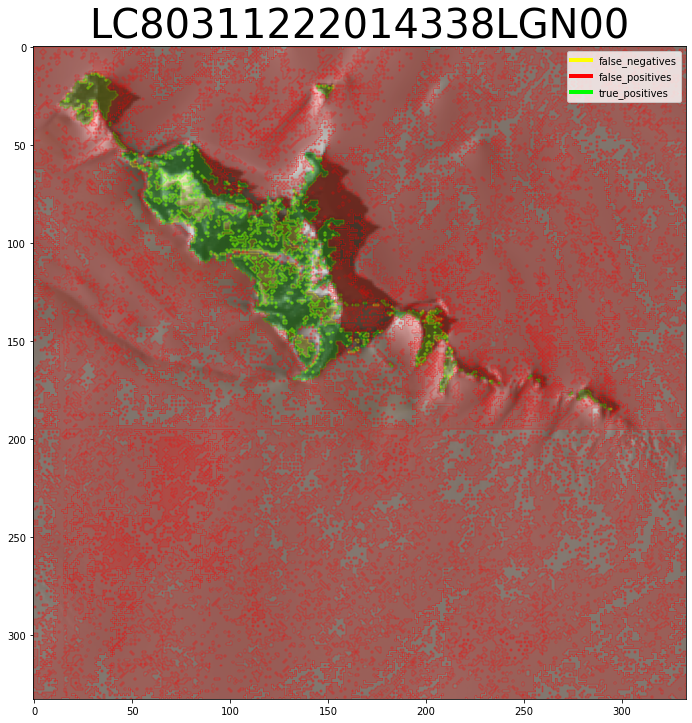

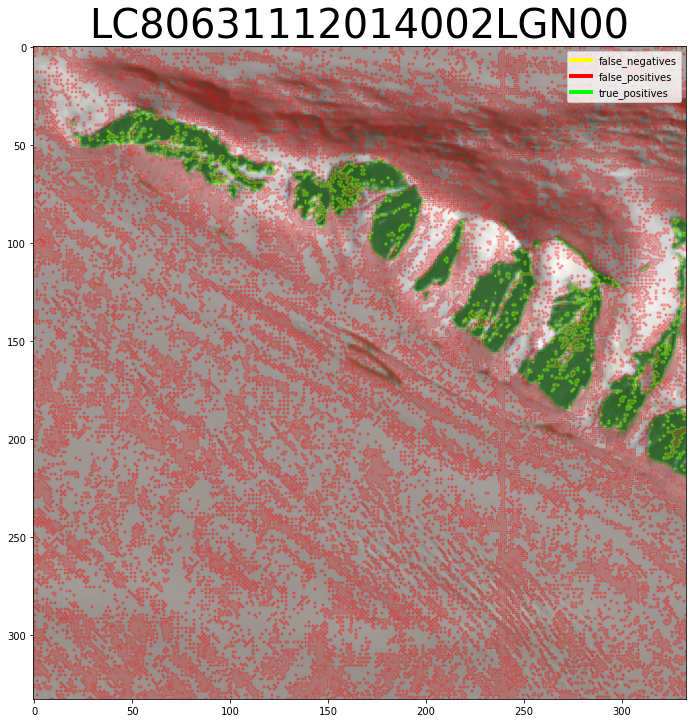

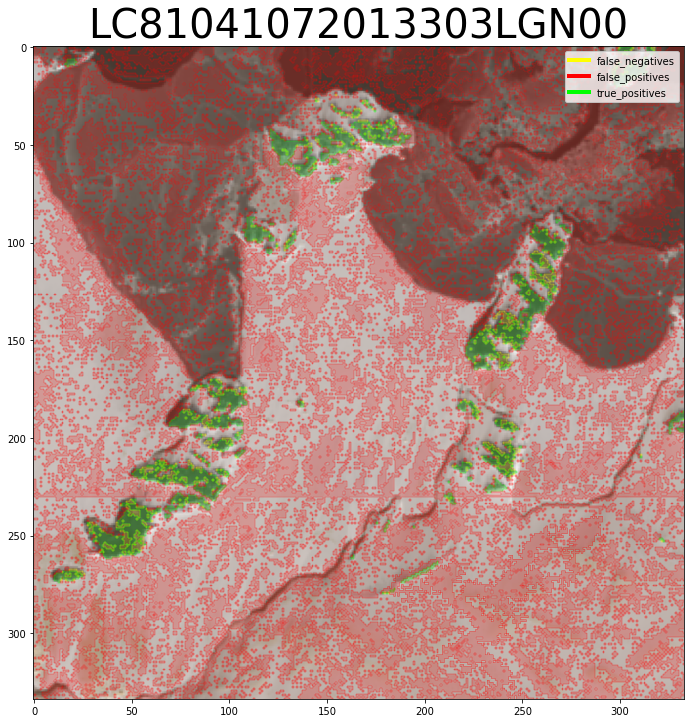

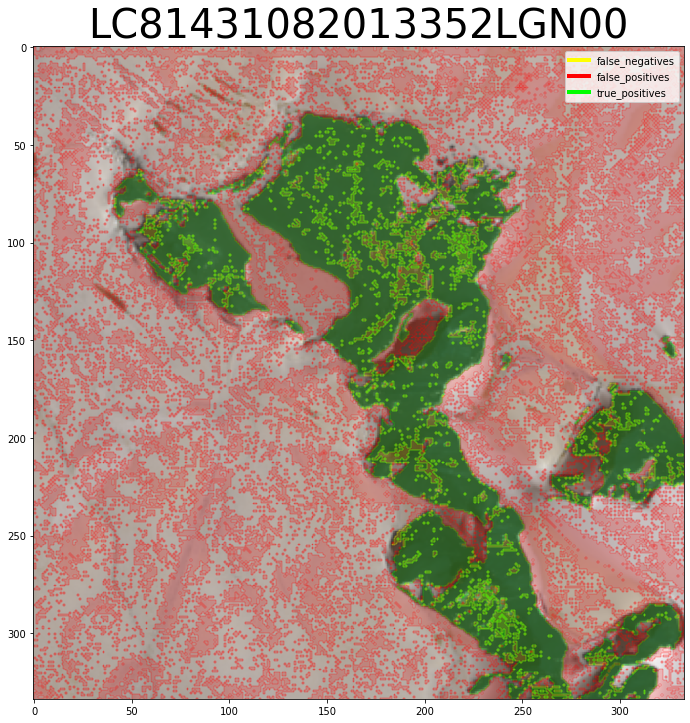

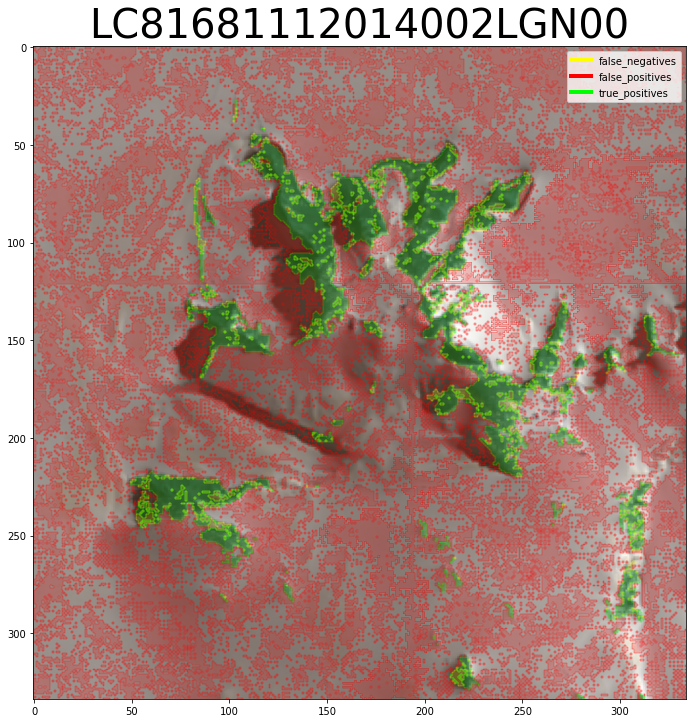

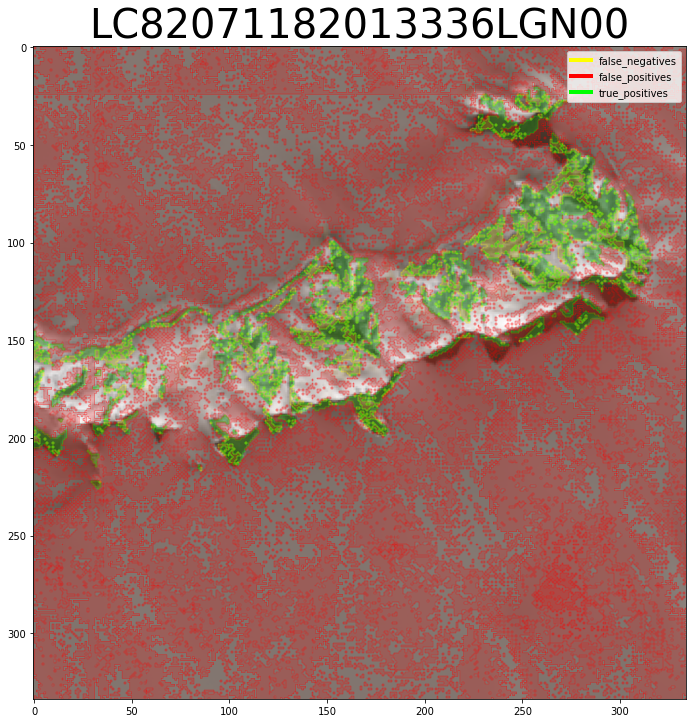

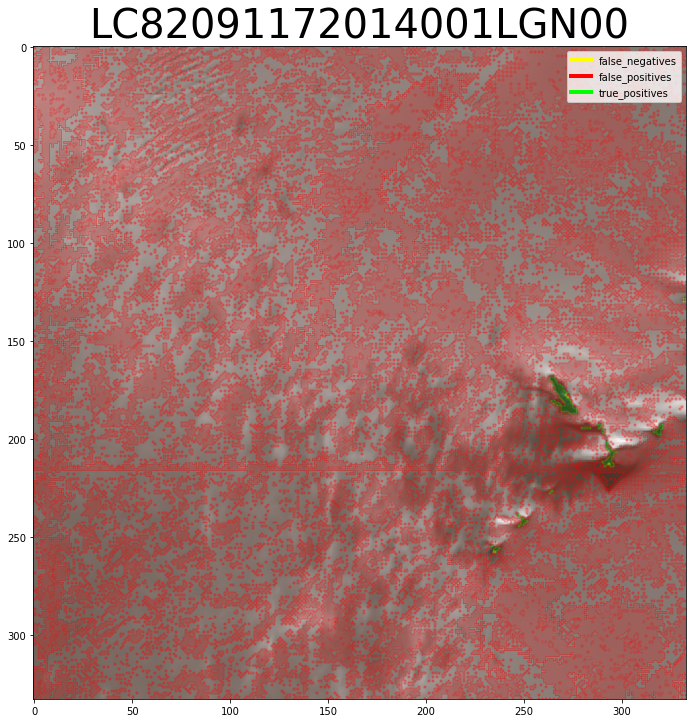

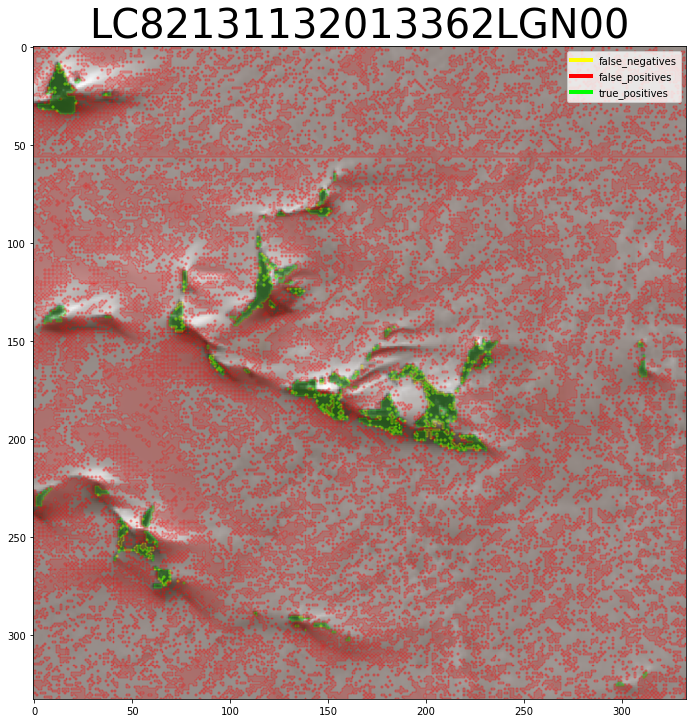

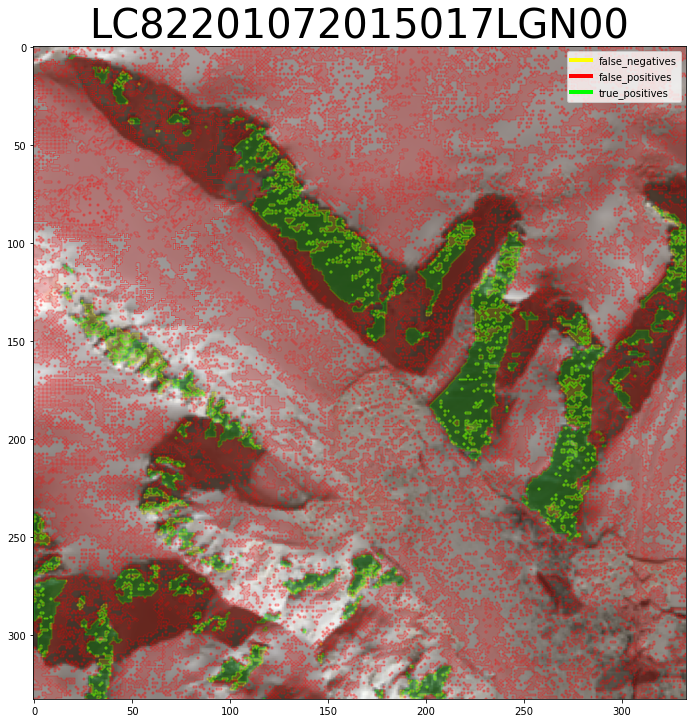

In [19]:
from matplotlib.lines import Line2D
results_figure_dir = os.path.join(base_dir, "figures", "results", model_name)
if not os.path.exists(results_figure_dir):
    os.makedirs(results_figure_dir)

for i in diff_rasters:
    polys = model_results.generate_shapes_from_diff(diff_rasters[i])
    fig, ax = plt.subplots(figsize=(12,12))
    
    ax.set_title(i, fontsize=40)
    legend_lines = []
    legend_labels = []
    # ("true_negatives", 'red'), 
    for j in [("false_negatives",'#ffff00'), ("false_positives", '#ff0000'),
            ("true_positives", '#00ff00'),]:
        legend_lines.append(Line2D([0], [0], color=j[1], lw=4))
        legend_labels.append(j[0])
        try:
            polys[j[0]].geometry.boundary.plot(facecolor='none', edgecolor=j[1], linewidth=0.3, ax=ax)
            polys[j[0]].plot(facecolor=j[1], edgecolor='none', alpha=0.2, ax=ax)
        except AttributeError:
            pass


    ax.imshow(norms[i][:,:,1:4])
    ax.legend(legend_lines, legend_labels)

    fig.savefig(os.path.join(results_figure_dir, "{}.png".format(i)), bbox_inches='tight', transparent=True)


### Visualize data bands

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [0]:
sample_stack = norms["LC80631112014002LGN00"]
band_figure_dir = os.path.join(base_dir, "figures", "bands")
if not os.path.exists(band_figure_dir):
    os.mkdir(band_figure_dir)

band_colors = [("Deep blues and violets", 'Purples_r'), ("Blue", 'Blues_r'), ("Green", "Greens_r"), ("Red", "Reds_r"), 
               ("Near Infrared", "Oranges_r"), ("Shortwave Infrared1", "pink"), ("Shortwave Infrared2", "pink"), ("Clouds", "binary"), ("Thermal Infrared", "coolwarm"),
               ("Thermal Infrared", "coolwarm")]
band_number = [1,2,3,4,5,6,7,9,10,11]
for i in range(10):
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(sample_stack[:,:,i], cmap=band_colors[i][1])
    ax.set_title("Band {}: {}".format(band_number[i], band_colors[i][0]), fontsize=40)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    fig.savefig(os.path.join(band_figure_dir, "Band_{}.png".format(band_number[i])), bbox='tight', transparent=True)

### Visualize Burton-Johnson et. al. Band combinations

In [0]:
tirs_v_blue = sample_stack[:,:,8] / sample_stack[:,:,1]

In [0]:
ndsi = (sample_stack[:,:,2] - sample_stack[:,:,5]) / (sample_stack[:,:,2] + sample_stack[:,:,5])

In [0]:
ndwi = (sample_stack[:,:,2] - sample_stack[:,:,4]) / (sample_stack[:,:,2] + sample_stack[:,:,4])

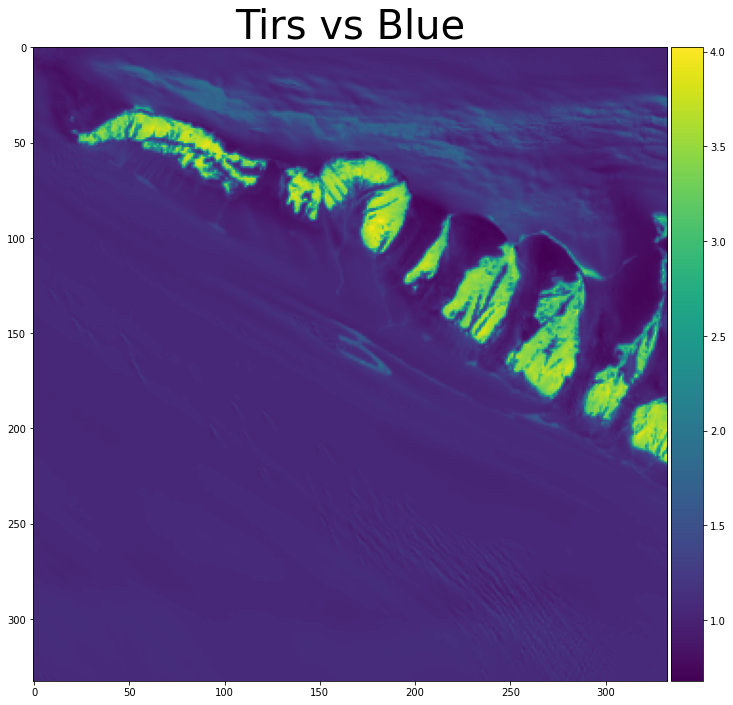

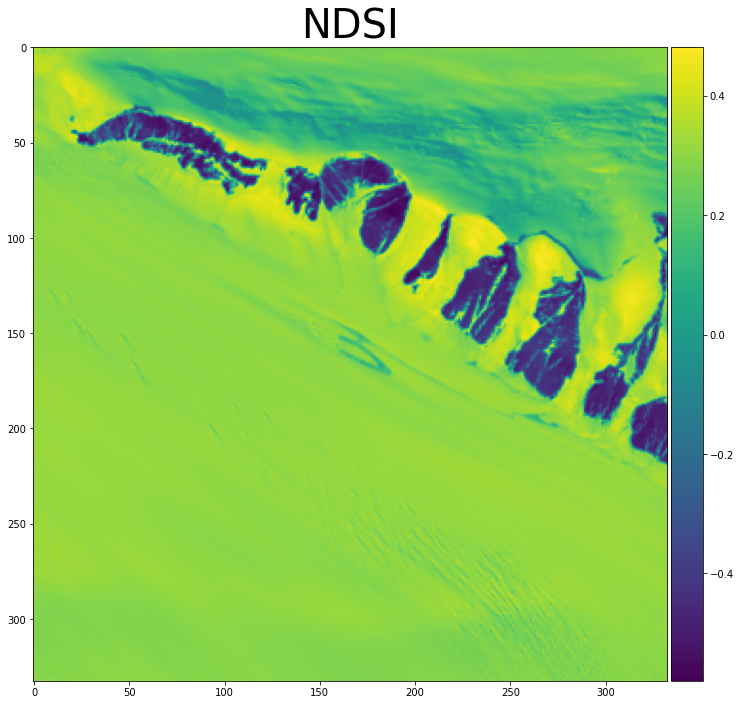

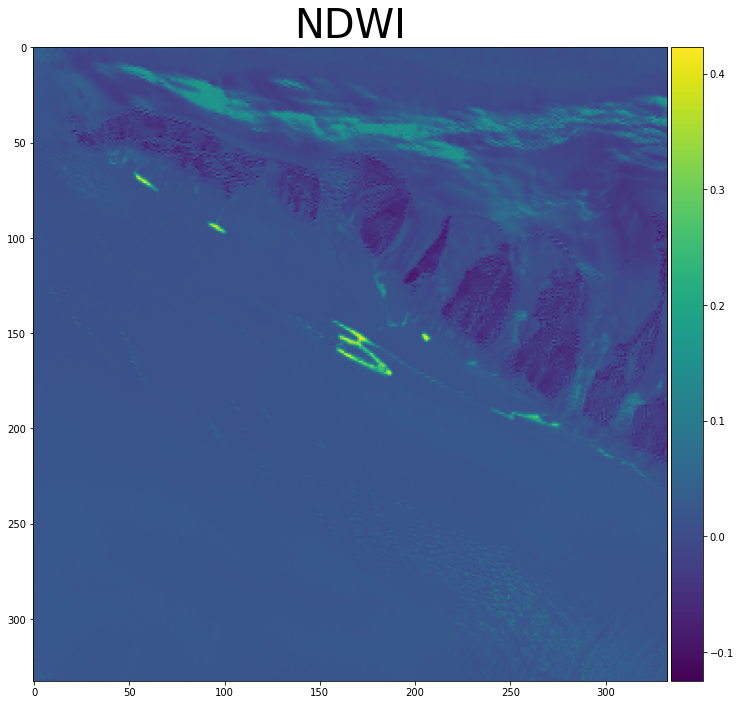

In [0]:
heuristic_dir = os.path.join(base_dir, "figures", "abj_heuristics")
if not os.path.exists(heuristic_dir):
    os.mkdir(heuristic_dir)

for i in [("Tirs vs Blue", tirs_v_blue), ("NDSI", ndsi), ("NDWI", ndwi)]:
    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(i[1])
    ax.set_title(i[0], fontsize=40)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    fig.savefig(os.path.join(heuristic_dir, "{}.png".format(i[0])), bbox='tight', transparent=True)

## Visualize metric trends

### Load image metadata

In [0]:
def scrape_metadata(path):
    fields = ["CLOUD_COVER", "IMAGE_QUALITY_OLI", "IMAGE_QUALITY_TIRS",
              "SUN_AZIMUTH", "SUN_ELEVATION", "EARTH_SUN_DISTANCE",
              "CORNER_UL_LAT_PRODUCT"]
    metadata = {}
    separator = " = "
    sep_len = len(separator)
    
    with open(path, 'r') as file:
        for i in file.readlines():
            try:
                separator_pos = i.index(separator)
                key = i[:separator_pos].strip()
                value = i[separator_pos + sep_len:].strip()
                for j in fields:
                    if key[:len(j)] == j:
                        metadata[j] = value
            except ValueError as e:
                pass
    return metadata

In [0]:
metadata = {}
for i in windows:
    if i == "ryder_bay_abj":
        metadata_path = os.path.join(base_dir, "qc", "image_metadata", "LC82201072015017LGN00_MTL.txt")
    else:
        metadata_path = os.path.join(base_dir, "qc", "image_metadata", "{}_MTL.txt".format(i))
    metadata[i] = scrape_metadata(metadata_path)

In [0]:
print(metadata)
print(diff_statistics)

{'LC80311222014338LGN00': {'CORNER_UL_LAT_PRODUCT': '-83.42702', 'CLOUD_COVER': '1.81', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '117.12274005', 'SUN_ELEVATION': '18.72338007', 'EARTH_SUN_DISTANCE': '0.9855587'}, 'LC80631112014002LGN00': {'CORNER_UL_LAT_PRODUCT': '-73.48063', 'CLOUD_COVER': '3.22', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '62.11020434', 'SUN_ELEVATION': '32.39885959', 'EARTH_SUN_DISTANCE': '0.9833397'}, 'LC81041072013303LGN00': {'CORNER_UL_LAT_PRODUCT': '-68.54996', 'CLOUD_COVER': '2.83', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '48.79628860', 'SUN_ELEVATION': '30.20659331', 'EARTH_SUN_DISTANCE': '0.9930934'}, 'LC81431082013352LGN00': {'CORNER_UL_LAT_PRODUCT': '-68.36069', 'CLOUD_COVER': '0.34', 'IMAGE_QUALITY_OLI': '9', 'IMAGE_QUALITY_TIRS': '9', 'SUN_AZIMUTH': '56.85080080', 'SUN_ELEVATION': '37.06220044', 'EARTH_SUN_DISTANCE': '0.9839594'}, 'LC81681112014002LGN00': {'CORNER_UL_LAT_PRODU

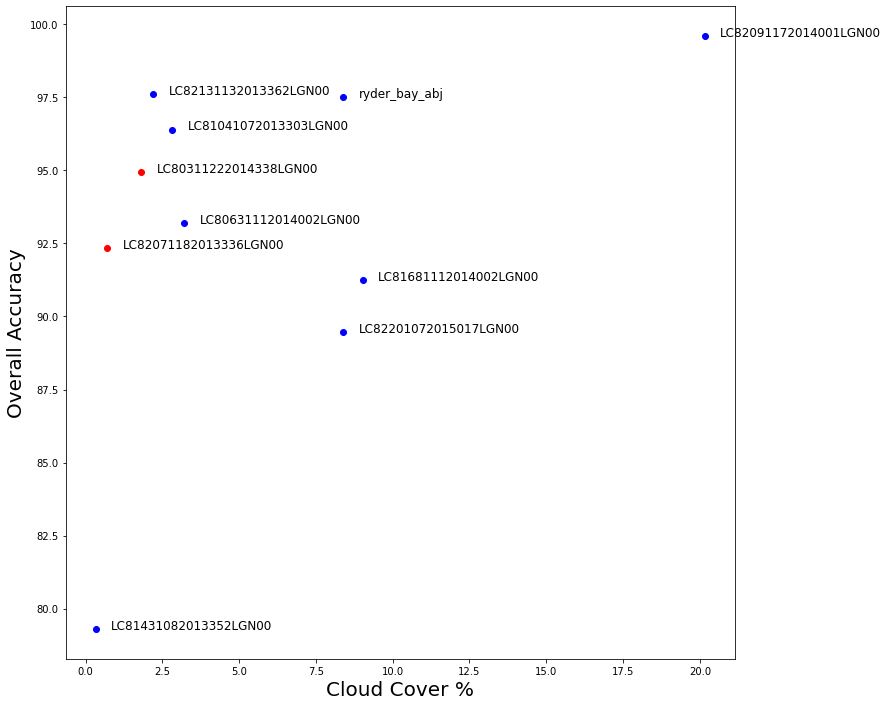

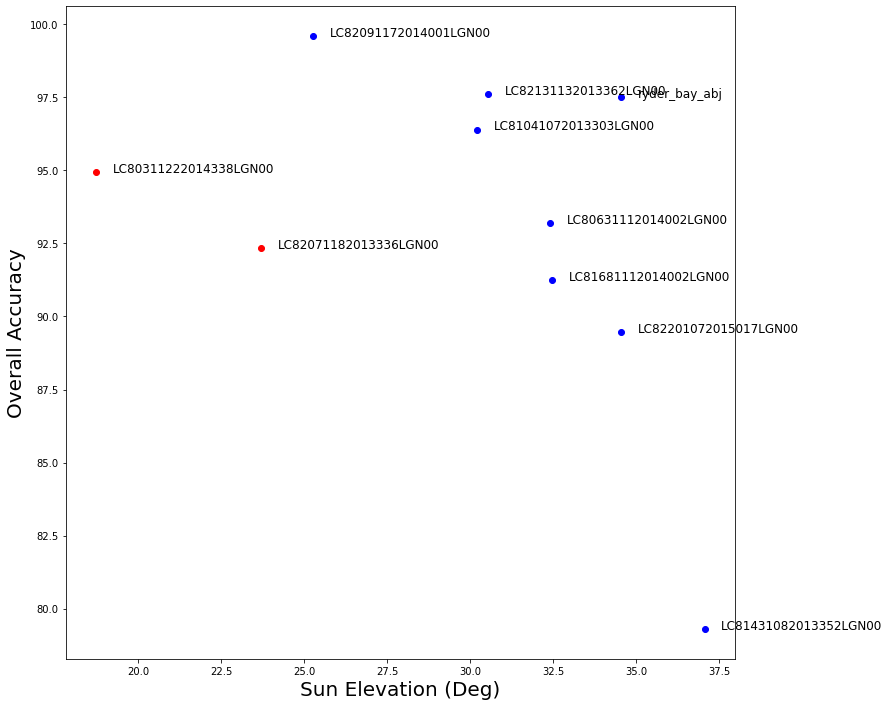

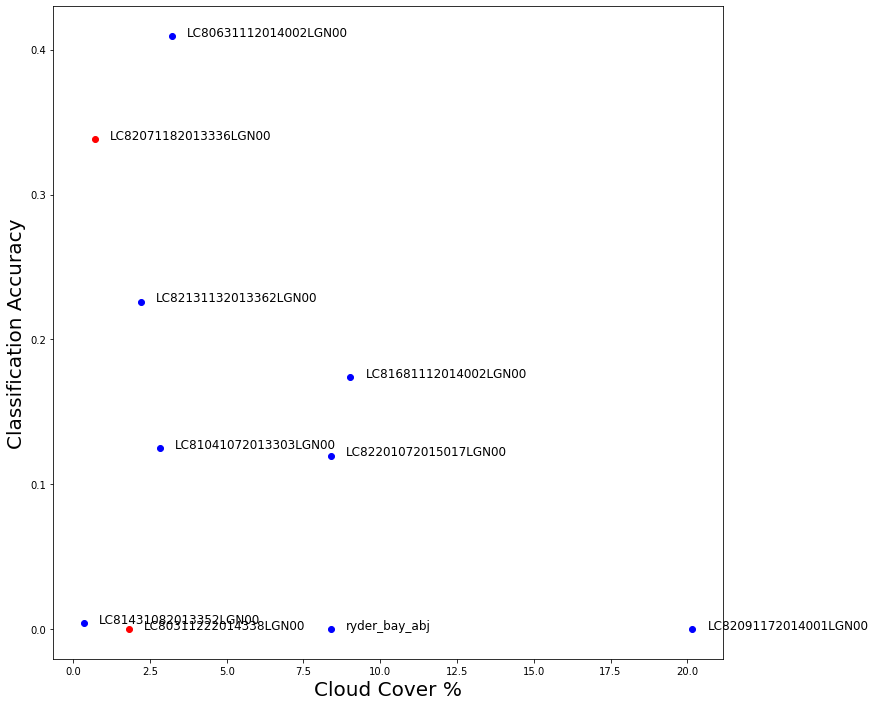

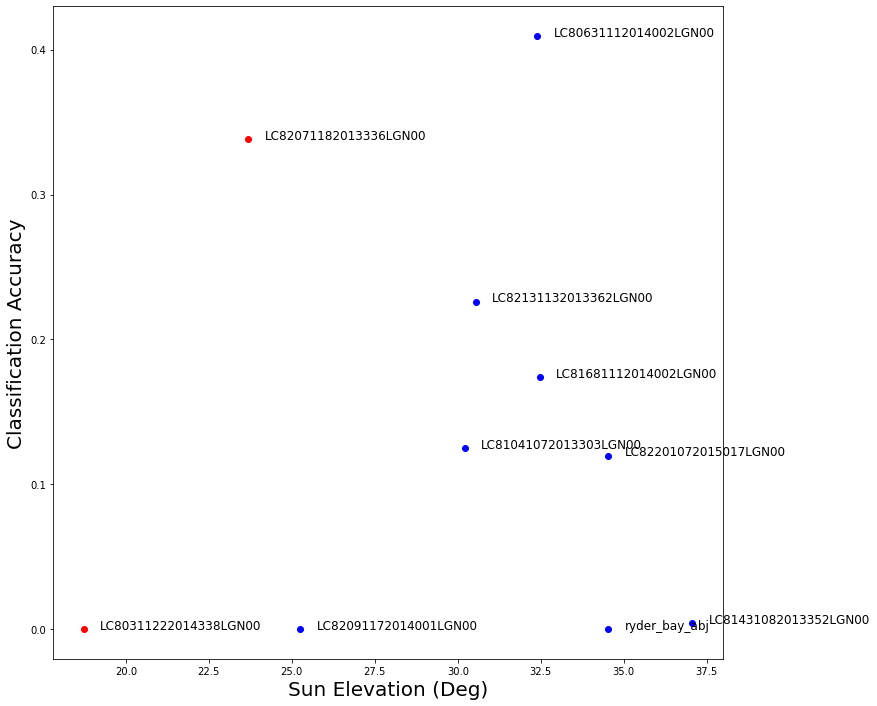

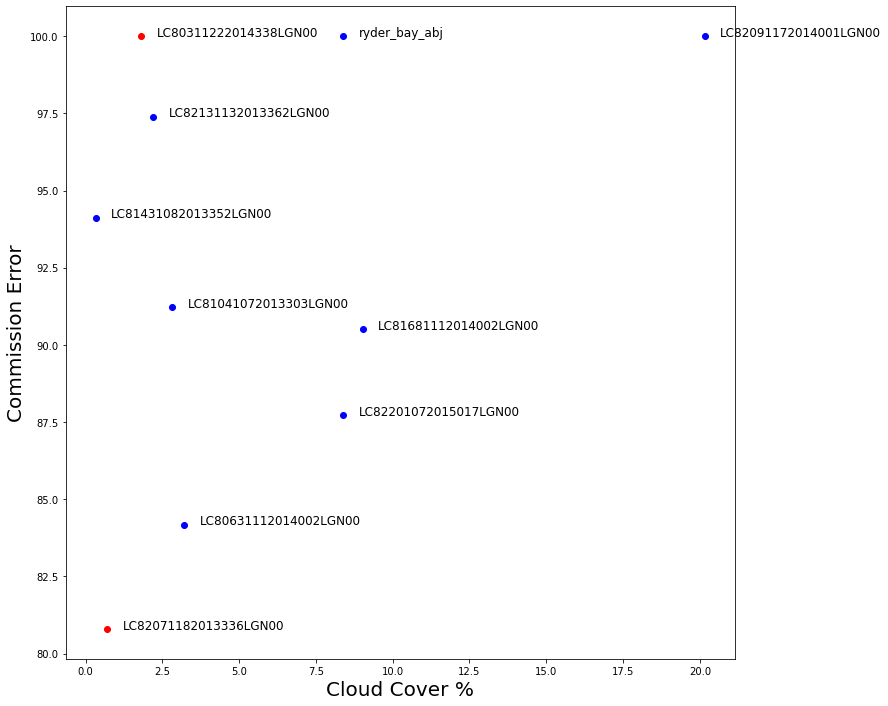

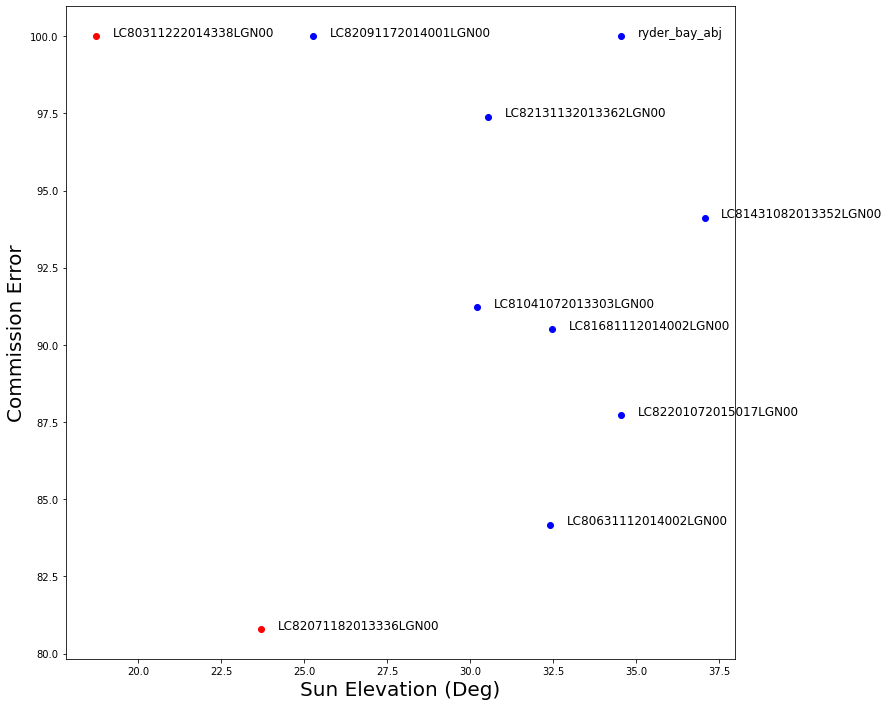

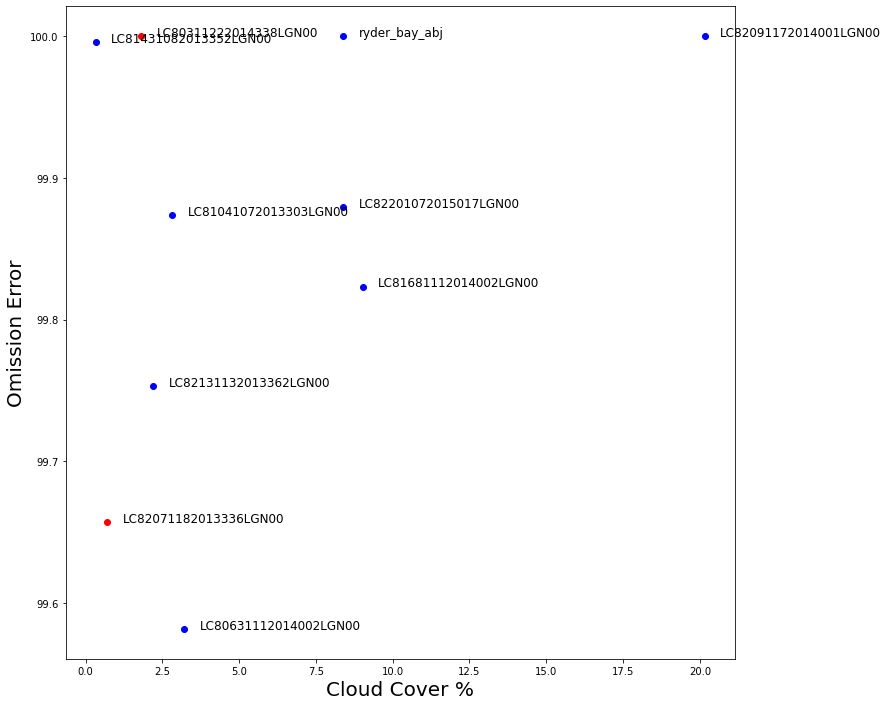

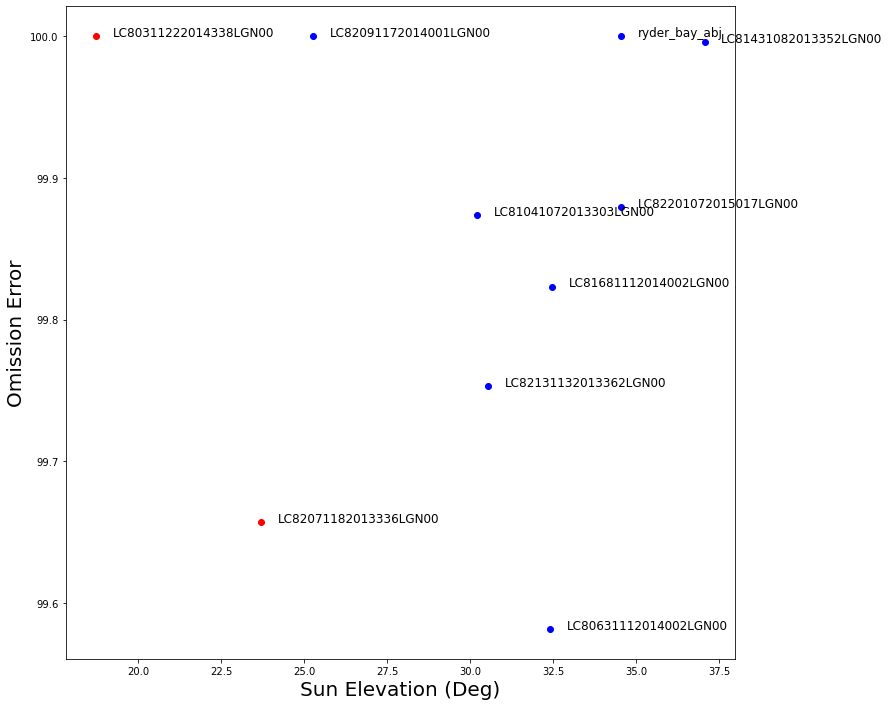

In [0]:
metrics = [("accuracy", "Overall Accuracy"), ("classification_accuracy", "Classification Accuracy"), ("rock_commission", "Commission Error"), ("rock_omission", "Omission Error")]
metadata_axes = [("CLOUD_COVER", "Cloud Cover %"), ("SUN_ELEVATION", "Sun Elevation (Deg)")]
scene_ids = list(diff_statistics.keys())
metric_trend_dir = os.path.join(base_dir, "figures", "metric_trends")
if not os.path.exists(metric_trend_dir):
    os.mkdir(metric_trend_dir)

for i in metrics:
    metric_set = [float(diff_statistics[k][i[0]]) * 100 for k in scene_ids]
    # print(len(metric_set))
    for j in metadata_axes:
        x = [float(metadata[k][j[0]]) for k in scene_ids]
        # print(len(y))
        fig, ax = plt.subplots(figsize=(12,12))
        # ax.set_title("Model Performance", fontsize=40)
        ax.set_xlabel(j[1], fontsize=20)
        ax.set_ylabel(i[1], fontsize=20)
        for k in range(len(scene_ids)):
            if scene_ids[k] in ["LC80311222014338LGN00", "LC82071182013336LGN00"]:
                ax.plot(x[k], metric_set[k], 'ro')
            else:
                ax.plot(x[k], metric_set[k], 'bo')
            ax.annotate(scene_ids[k], (x[k] + .5, metric_set[k]), fontsize=12)
        fig.savefig(os.path.join(metric_trend_dir, "{}_vs_{}.png".format(j[1], i[1])), bbox='tight', transparent=True)
        

# batch stat generation


In [0]:
models = []
for j in os.listdir(os.path.join(base_dir, 'output')):
    output_path = os.path.join(os.path.join(base_dir, 'output', j))
    try:
        output_chunks = model_results.load_output_mosaics(output_path)
    except FileNotFoundError as e:
        models.append((j, str(e))) 
        continue

    if len(output_chunks) == 0:
        models.append((j, "output_chunk len is zero"))
        continue

    diffs = model_results.generate_diffs(output_chunks)
    diff_histograms = model_results.generate_diff_histograms(diffs)
    average_classification_accuracy = 0
    for i in output_chunks:
        average_classification_accuracy += model_assessment.calculate_results(diff_histograms[i])['classification_accuracy']
        
    average_classification_accuracy /= len(output_chunks)
    models.append((j, average_classification_accuracy))

/content/drive/My Drive/lasero/utils/model_assessment.py:33: RuntimeWarning: invalid value encountered in long_scalars
  stats["rock_commission"] = diff_histogram[2] / (diff_histogram[2] + diff_histogram[3])
/content/drive/My Drive/lasero/utils/model_assessment.py:40: RuntimeWarning: invalid value encountered in long_scalars
  stats["rock_users"] = diff_histogram[3] / (diff_histogram[2] + diff_histogram[3]) * 100
/content/drive/My Drive/lasero/utils/model_assessment.py:35: RuntimeWarning: invalid value encountered in long_scalars
  stats["notrock_commission"] = diff_histogram[1] / (diff_histogram[0] + diff_histogram[1])
/content/drive/My Drive/lasero/utils/model_assessment.py:41: RuntimeWarning: invalid value encountered in long_scalars
  stats["notrock_users"] = diff_histogram[0] / (diff_histogram[0] + diff_histogram[1]) * 100


In [0]:
# for i in models:
#     print(i)

import shutil
for i, j in models:
    if isinstance(j, float) and j > 0.0:
        print(i, j)
        continue
    output_dir = os.path.join(base_dir, 'output', i)
    print(i, os.path.isdir(output_dir))
    # shutil.rmtree(output_dir)

model_rich_feature_all_bands_0 0.30286905139883014
model_rich_feature_0 0.357685324802241
model_allBands_best_lr_0.01 0.3164965933821715
model_allBands_best_lr_0.02 0.0011192087454450807
model_allBands_sgd_best_lr_0.01 0.0028666755054422284
model_allBands_epoch45_lr_0.01 0.165197454152603
model_allBands_epoch30_lr_0.01 0.21476202153792487
model_allBands_epoch20_lr_0.01 0.18444711847339132
model_allBands_epoch35_lr_0.01 0.2928283655972925
model_allBands_epoch40_lr_0.01 0.19595392326214364
model_allBands_epoch50_lr_0.01 0.3164965933821715
model_allBands_best_lr_0.01_wt_eq1 0.22932248928908577
model_Bands_thermal_best_lr_0.01 0.04623463887516103
model_Bands_All_NoClouds_focal_loss_epoch15_lr_0.01 0.0013211553914336924
model_allBands_best_lr_0.01_iou_loss_ 0.05169757921215752
model_Bands_All_NoClouds_focal_loss_epoch20_lr_0.01 0.11525194981120086
model_Bands_All_NoClouds_focal_loss_epoch30_lr_0.01 0.04138590490784436
model_Bands_All_NoClouds_focal_loss_class_weight1:3_best_lr_0.001 0.01768